
# Step 1: Load and Clean the Dataset


In [1]:
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


uploaded = files.upload()


# load ratings
ratings = pd.read_csv("ratings.csv")
print("Original ratings file:")
display(ratings.head())

#keep only the required columns
ratings = ratings[['userId', 'movieId', 'rating']]
print("After keeping only required columns:")
display(ratings.head())

#print the dataset info
print("Dataset information:")
ratings.info()

#basic statistics
print("\nBasic statistics:")
display(ratings.describe())


Saving links.csv to links (2).csv
Saving movies.csv to movies (2).csv
Saving ratings.csv to ratings (2).csv
Saving tags.csv to tags (2).csv
Original ratings file:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


After keeping only required columns:


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB

Basic statistics:


,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


#Step 2 — Exploratory Data Analysis (EDA)


/tmp/ipython-input-3610801777.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis',legend=False)


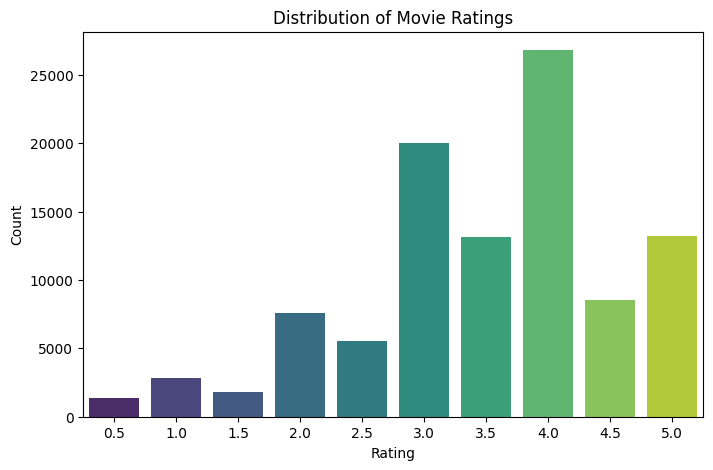

In [2]:

#This graph shows the distribution of all rating values from 0.5 to 5.
plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=ratings, palette='viridis',legend=False)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()





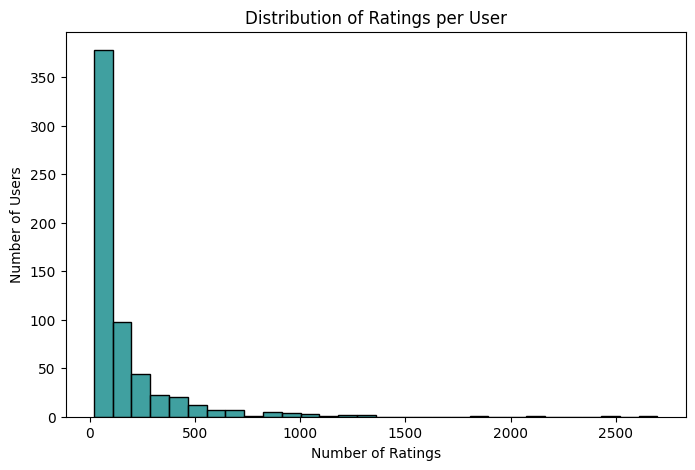

In [3]:
#This graph displays how many ratings each user provides.
plt.figure(figsize=(8,5))
ratings_per_user = ratings.groupby('userId').size()
sns.histplot(ratings_per_user, bins=30, kde=False, color='teal')
plt.title("Distribution of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()


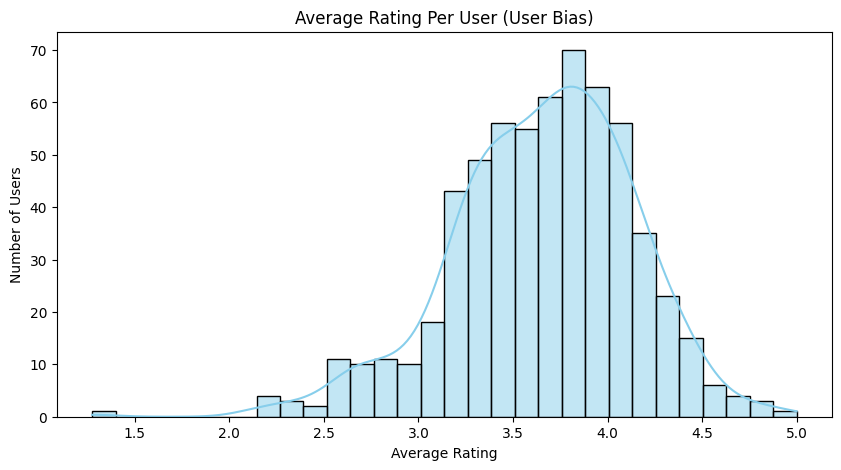

In [4]:
#average rating per user
user_mean = ratings.groupby('userId')['rating'].mean()
plt.figure(figsize=(10,5))
sns.histplot(user_mean, bins=30, kde=True, color='skyblue')
plt.title("Average Rating Per User (User Bias)")
plt.xlabel("Average Rating")
plt.ylabel("Number of Users")
plt.show()


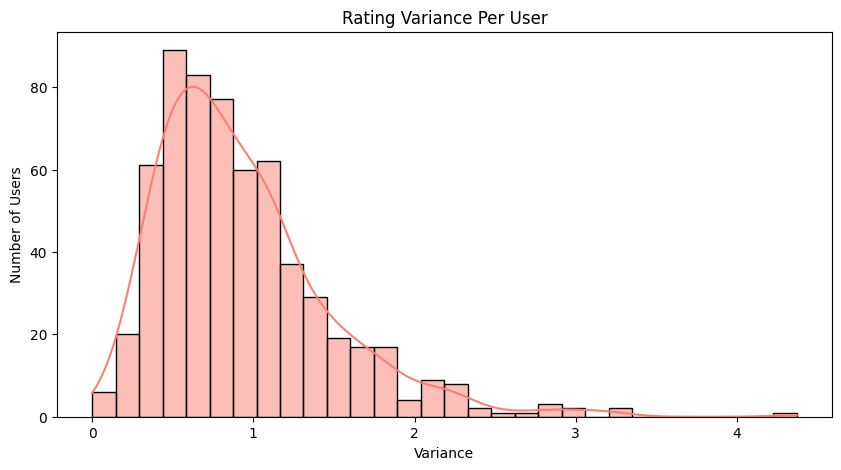

In [5]:
#the variance of the ratings per user
user_var = ratings.groupby('userId')['rating'].var().dropna()
plt.figure(figsize=(10,5))
sns.histplot(user_var, bins=30, kde=True, color='salmon')
plt.title("Rating Variance Per User")
plt.xlabel("Variance")
plt.ylabel("Number of Users")
plt.show()


<Figure size 1000x500 with 0 Axes>

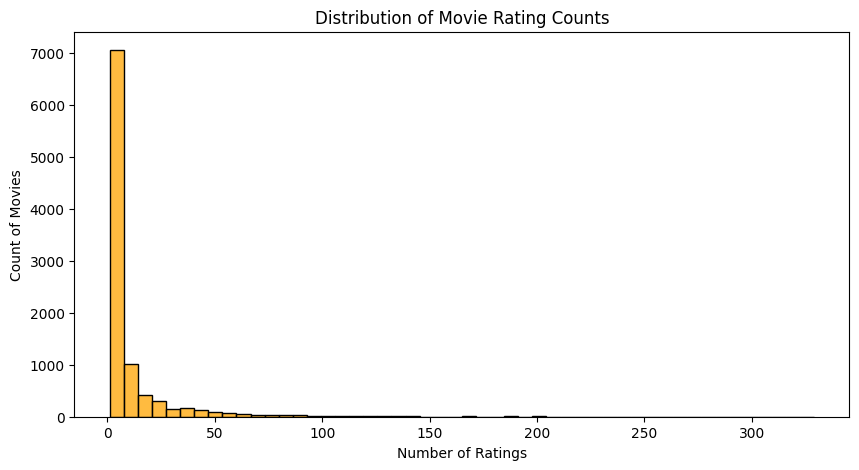

In [6]:
#This plot shows how many ratings each movie receives.
plt.figure(figsize=(10,5))
movie_count = ratings.groupby('movieId').size()
plt.figure(figsize=(10,5))
sns.histplot(movie_count, bins=50, log_scale=False, color='orange')
plt.title("Distribution of Movie Rating Counts")
plt.xlabel("Number of Ratings")
plt.ylabel("Count of Movies")
plt.show()


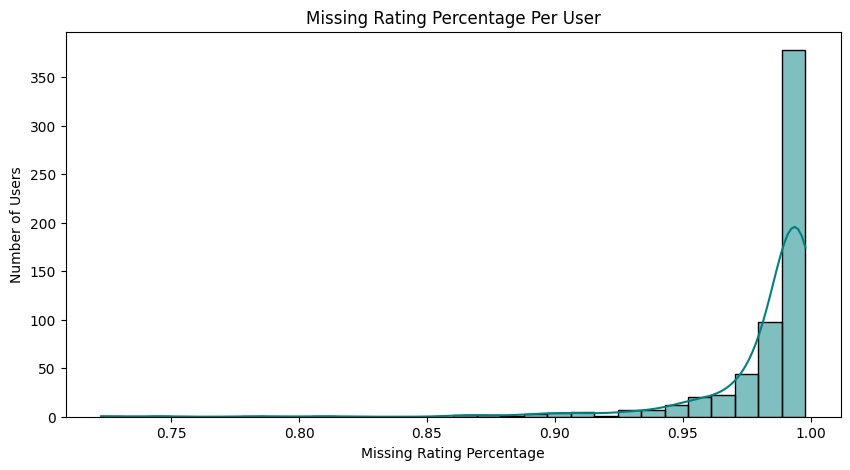

In [7]:
import numpy as np

#total movies
num_movies = ratings['movieId'].nunique()

#missing rate per user
user_count = ratings.groupby('userId')['movieId'].nunique()
missing_rate = 1 - (user_count / num_movies)

plt.figure(figsize=(10,5))
sns.histplot(missing_rate, bins=30, kde=True, color='teal')
plt.title("Missing Rating Percentage Per User")
plt.xlabel("Missing Rating Percentage")
plt.ylabel("Number of Users")
plt.show()


#Step 3 — Memory-Based Collaborative Filtering (KNN)

We need to implement:

✔ User-Based Collaborative Filtering (KNN + Cosine)

✔ Item-Based Collaborative Filtering (KNN + Cosine)

✔ Evaluate both using 5-Fold Cross Validation

✔ For K = [3, 5, 10]

✔ Collect MSE and MAE

✔ Produce 4 graphs:

- User-Based MSE vs K

- User-Based MAE vs K

- Item-Based MSE vs K

- Item-Based MAE vs K

We will do this using the Surprise library.

In [8]:
!pip install scikit-surprise


In [9]:
!pip install numpy==1.26.4


In [10]:
from surprise import Dataset, Reader, KNNBasic
from surprise import SVD, SVDpp, NMF
from surprise.model_selection import KFold
from surprise import accuracy


In [11]:
#step 3A - load data into surprise format
#load data into surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


In [12]:
#step 3B - function to evaluate KNN models

def evaluate_knn(sim_type='cosine', user_based=True, k_values=[3,5,10]):
    mse_results = []
    mae_results = []

    for k in k_values:

        algo_used = KNNBasic(k=k,sim_options={'name': sim_type,'user_based': user_based})
        kf = KFold(n_splits=5)
        fold_mse = []
        fold_mae = []

        for trainset, testset in kf.split(data):
            algo_used.fit(trainset)
            predictions = algo_used.test(testset)
            fold_mse.append(accuracy.mse(predictions, verbose=False))
            fold_mae.append(accuracy.mae(predictions, verbose=False))

        mse_results.append(np.mean(fold_mse))
        mae_results.append(np.mean(fold_mae))

    return mse_results, mae_results



In [13]:
#step 3C - run User-Based CF
k_values = [3, 5, 10]

user_mse, user_mae = evaluate_knn(user_based=True,k_values=k_values)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [14]:
#step 3D — Run Item-Based CF
item_mse, item_mae = evaluate_knn(user_based=False,k_values=k_values)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

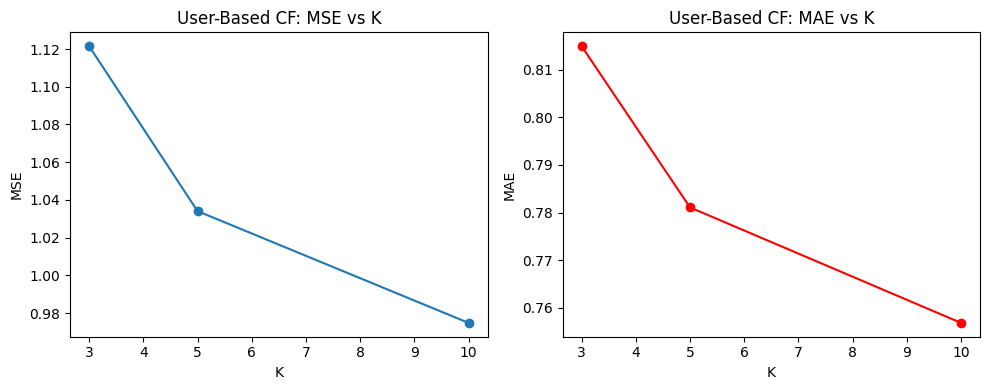

In [15]:
#step 3E — Plot the Results

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(k_values, user_mse, marker='o')
plt.title("User-Based CF: MSE vs K")
plt.xlabel("K")
plt.ylabel("MSE")

plt.subplot(1,2,2)
plt.plot(k_values, user_mae, marker='o', color='red')
plt.title("User-Based CF: MAE vs K")
plt.xlabel("K")
plt.ylabel("MAE")

plt.tight_layout()
plt.show()


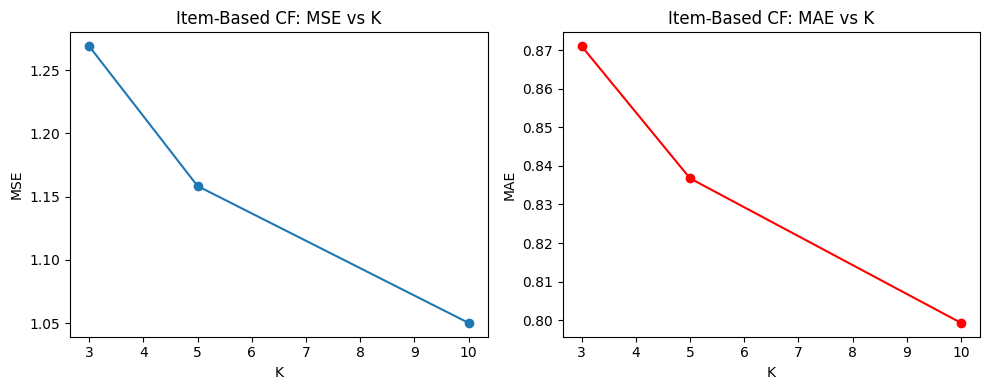

In [16]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(k_values, item_mse, marker='o')
plt.title("Item-Based CF: MSE vs K")
plt.xlabel("K")
plt.ylabel("MSE")

plt.subplot(1,2,2)
plt.plot(k_values, item_mae, marker='o', color='red')
plt.title("Item-Based CF: MAE vs K")
plt.xlabel("K")
plt.ylabel("MAE")

plt.tight_layout()
plt.show()


# Step 4 - Model-Based Collaborative Filtering

In [17]:
#step 4A – evaluation function for any model
def evaluate_model(algo, data, n_splits=5):
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    mse_scores = []
    mae_scores = []

    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        preds = algo.test(testset)

        mse_scores.append(accuracy.mse(preds, verbose=False))
        mae_scores.append(accuracy.mae(preds, verbose=False))

    return np.mean(mse_scores), np.mean(mae_scores)


In [18]:
#step 4B - run SVD, SVD++, NMF

models = {"SVD":SVD(),"SVD++":SVDpp(),"NMF":NMF()}

results = []

for name, algo in models.items():
    print(f"Evaluating {name}")
    mse, mae = evaluate_model(algo, data, n_splits=5)
    results.append({"Model": name, "MSE": mse, "MAE": mae})
    print(f"{name} -> MSE: {mse:.4f}, MAE: {mae:.4f}")


Evaluating SVD
SVD -> MSE: 0.7617, MAE: 0.6703
Evaluating SVD++
SVD++ -> MSE: 0.7443, MAE: 0.6614
Evaluating NMF
NMF -> MSE: 0.8499, MAE: 0.7061


In [19]:
#step 4C – summary table

results_df = pd.DataFrame(results)
results_df = results_df.set_index("Model")
results_df


,MSE,MAE
Model,,
SVD,0.761676,0.670264
SVD++,0.744307,0.661430
NMF,0.849884,0.706101
